In [15]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns



The 3 images shown - are their resulting activations?


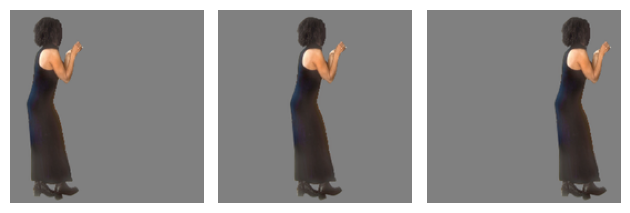

['stimulus7_left.tif', 'stimulus7.tif', 'stimulus7_right.tif']

In [16]:
# First do some analysis on the translation test - see if my understanding of representations are right

path2activations = '/data/alban/activations/saycam_hmIT_Translationtest'
path2dataset = 'testsets/hmIT_Translationtest'

listimages = os.listdir(path2dataset)
fig, subs = plt.subplots(1,3)
for i, img in enumerate(listimages):
    img = cv2.imread(join(path2dataset, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    subs[i].imshow(img)
    subs[i].axis('off')
print('The 3 images shown - are their resulting activations?')
fig.tight_layout()
plt.show()

listimages

In [17]:
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
patch_token.shape

(3, 7680000)

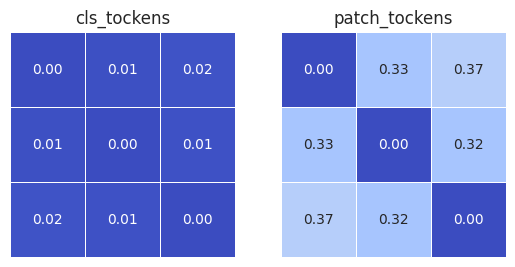

In [18]:
### Correlations
corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1- corr_cls,
            annot=True,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1- corr_patch,
            annot=True,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()



In [19]:
## Dot product

def similarity_dotproduct(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (cosine similarity)
    similarity_matrix = np.dot(vectors_normalized, vectors_normalized.T)
    # Convert to dissimilarity: 1 - similarity
    return 1 - similarity_matrix

dot_cls = similarity_dotproduct(cls_token)
dot_patch = similarity_dotproduct(patch_token)



Let's try with L2 norm as a metric of similarity (after normalization). nt

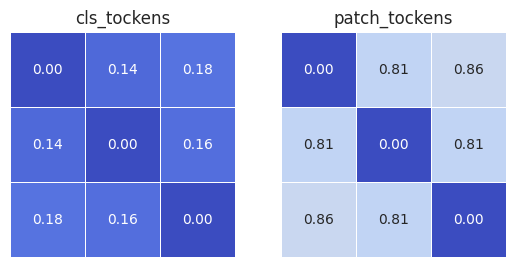

In [20]:
## L2 norm

from scipy.spatial.distance import pdist, squareform

def similarity_L2norm(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (l2 norm similarity)
    distances = pdist(vectors_normalized, 'euclidean')
    # Convert to dissimilarity: 1 - similarity
    return squareform(distances)

l2_cls = similarity_L2norm(cls_token)
l2_patch = similarity_L2norm(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(l2_cls,
            annot=True,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

sns.heatmap(l2_patch,
            annot=True,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()


As we did expect, we have low dissimilarity scores when using the cls_tokens as representations, and mid when suing the patch tokens. This suggests that the cls tokens are largely agnostic of spatial properties, and thus more appropriate to compare how semantic information is being represented.

Let's do the same with the actual 92 images.

In [21]:
# Get image paths and the dataset's metadata
from natsort import natsorted


import pandas as pd
df = pd.read_excel('testsets/metadata_hmIT/mapping.xlsx')
print(df)


       class1      class2  class3     image  informed_exclude
0     animate       human    body  0001.jpg                 0
1     animate       human    body  0002.jpg                 0
2     animate       human    body  0003.jpg                 0
3     animate       human    body  0004.jpg                 0
4     animate       human    body  0005.jpg                 0
..        ...         ...     ...       ...               ...
87  inanimate  artificial  object  0088.jpg                 0
88  inanimate  artificial  object  0089.jpg                 0
89  inanimate  artificial  object  0090.jpg                 1
90  inanimate  artificial  object  0091.jpg                 0
91  inanimate  artificial  object  0092.jpg                 0

[92 rows x 5 columns]


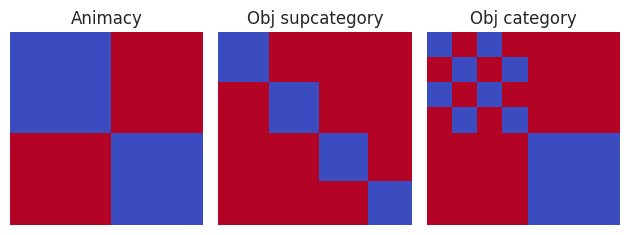

In [22]:

# Create similarity matrices for animacy
animate = df['class1'] == 'animate'
inanimate = df['class1'] == 'inanimate'
corr_animacy = np.corrcoef(np.stack([animate,inanimate], axis =1))

# Create similarity matrices for all object supcategories
human = df['class2'] == 'human'
animal = df['class2'] == 'animal'
natural = df['class2'] == 'natural'
artificial = df['class2'] == 'artificial'
corr_supobj = np.corrcoef(np.stack([human,animal, natural, artificial], axis =1))

#create similarity matrice for object categories
labels = df['class3'].unique()
vecs = list()
for label in labels:
    vecs.append(df['class3'] == label)
corr_obj = np.corrcoef(np.stack(vecs, axis =1))

fig, subs = plt.subplots(1,3)
sns.heatmap(1-corr_animacy,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_supobj,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_obj,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[2],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale


subs[0].set_title('Animacy')
subs[1].set_title('Obj supcategory')
subs[2].set_title('Obj category')

subs[0].axis('off')
subs[1].axis('off')
subs[2].axis('off')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_classes.png', dpi=300, bbox_inches='tight')


We made a list of all the files of activatin

In [23]:
path2activations = '/data/alban/activations/saycam_hmIT_stimuli'
path2dataset = 'testsets/hmIT_stimuli'

listimages = os.listdir(path2dataset)
listimages = natsorted(listimages)
listimages

cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
cls_token.shape

(92, 768)

In [24]:
### Similarity matrices according to both metrics

corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

l2_cls = similarity_L2norm(cls_token)
l2_patch = similarity_L2norm(patch_token)


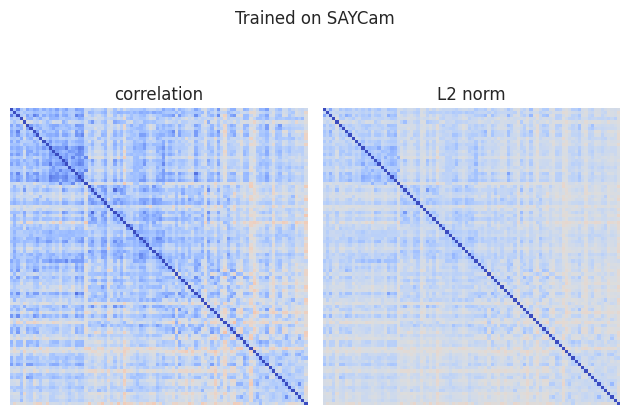

In [25]:

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1-corr_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(l2_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

subs[0].set_title('correlation')
subs[1].set_title('L2 norm')

subs[0].axis('off')
subs[1].axis('off')
fig.suptitle('Trained on SAYCam')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_saycam.png', dpi=300, bbox_inches='tight')


In [26]:
### Paths to activations EGO
path2activations = '/data/alban/activations/ego_hmIT_stimuli'
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
cls_token.shape

(92, 768)

In [27]:
### Similarity matrices according to both metrics

corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

l2_cls = similarity_L2norm(cls_token)
l2_patch = similarity_L2norm(patch_token)


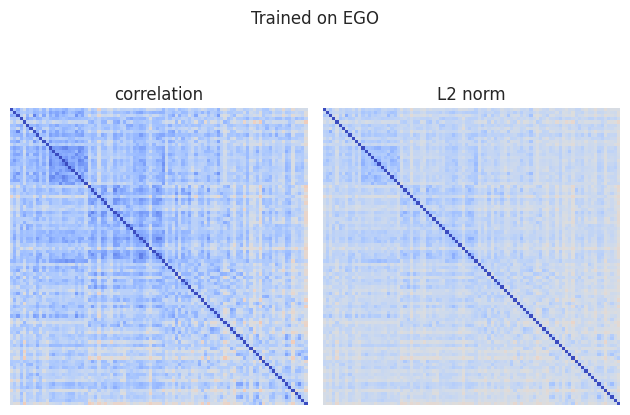

In [28]:

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1-corr_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(l2_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)            # Set maximum value for color scale, here sqrt(2)

subs[0].set_title('correlation')
subs[1].set_title('L2 norm')

subs[0].axis('off')
subs[1].axis('off')
fig.suptitle('Trained on EGO')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_ego.png', dpi=300, bbox_inches='tight')


In [29]:
### Paths to activations EGO
path2activations = '/data/alban/activations/imagenet_hmIT_stimuli'
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
cls_token.shape

(92, 768)

In [30]:
### Similarity matrices according to both metrics

corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

l2_cls = similarity_L2norm(cls_token)
l2_patch = similarity_L2norm(patch_token)


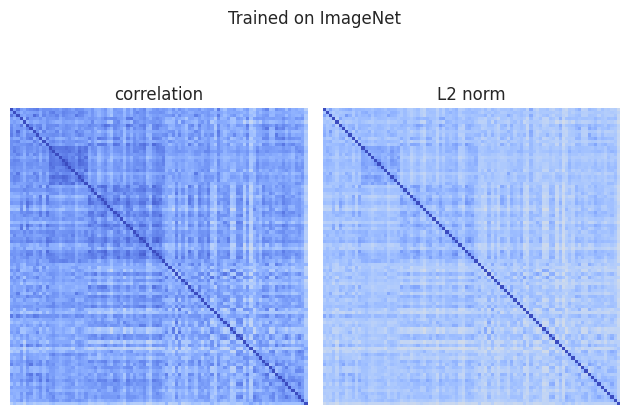

In [31]:

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1-corr_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(l2_cls,
            annot=False,
            cmap='coolwarm',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)            # Set maximum value for color scale, here sqrt(2)

subs[0].set_title('correlation')
subs[1].set_title('L2 norm')

subs[0].axis('off')
subs[1].axis('off')
fig.suptitle('Trained on ImageNet')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_imagenet.png', dpi=300, bbox_inches='tight')